## Title

In today's digital age, a significant amount of information is still stored in analog formats, such as handwritten notes, printed documents, and signage. Converting this analog text into digital format can be a time-consuming and error-prone process, hindering productivity and accessibility.  Our solution aims to accurately interpret text content from images and convert it into editable digital format. This technology has the potential to revolutionize various industries, including document digitization, data analysis, and accessibility services.

# Importing necesary libraries

In [1]:
#pip install opencv-python
#!pip install -q keras-ocr
#!pip install tensorflow

In [ ]:
!pip install firebase-admin

In [2]:
import cv2
import matplotlib.pyplot as plt
import keras_ocr
import math
import pandas as pd
import numpy as np
from difflib import get_close_matches

In [14]:
def process_image(images):
    # Load the image
    for imgpath in images:
        img = cv2.imread(imgpath)

        # Initialize the Keras OCR pipeline
        pipeline = keras_ocr.pipeline.Pipeline()

        # Extract text from the
        predictions = pipeline.recognize([img])[0]

        #Plot the image with the extracted text
        fig, ax = plt.subplots(figsize=(3, 4))
        keras_ocr.tools.drawAnnotations(image=img, predictions=predictions, ax=ax)
        plt.show()
        #print ("\nFirst two tuples:",predictions[0],'\n',predictions[1])
        #print ("Type of predictions:",type(predictions))
        #print ("Type of items in predictions:",type(predictions[0]))
        #print ("Type of the words:",type(predictions[0][0]))
        #print ("Type of its position:",type(predictions[0][1]))
        #print("top-left:",predictions[0][1][0])
        #print("top-right:",predictions[0][1][1])
        #print("bottom-left:",predictions[0][1][2])
        #print("bottom-right:",predictions[0][1][3])
    return predictions
'''This will return a tuple consisting of string and array of its position in the order of...(word, ([[top-left], [top-right],
[bottom-right], [bottom-left]]))'''

'This will return a tuple consisting of string and array of its position in the order of...(word, ([[top-left], [top-right],\n[bottom-right], [bottom-left]]))'

The text was extracted from an image using Keras-OCR and sorted using the Pythagorean Theorem. The center of each bounding box is measured in distances from the origin (0,0), and the list of distances is sorted according to unique rows and columns. If the triangle widens, the row remains the same; if it grows longer beyond the given threshold, the row changes. The results are stored in a list of dictionaries containing multiple key-value pairs.

In [4]:
def get_distance(predictions):
    """
    Function returns dictionary with (key,value):
        * text : detected text in image
        * center_x : center of bounding box (x)
        * center_y : center of bounding box (y)
        * distance_from_origin : hypotenuse
        * distance_y : distance between y and #origin (0,0)
    """
    
    # Point of origin
    x0, y0 = 0, 0
    detections = []
    for group in predictions:
        # Get center point of bounding box
        top_left_x, top_left_y = group[1][0]
        bottom_right_x, bottom_right_y = group[1][1]
        center_x = (top_left_x + bottom_right_x) / 2
        center_y = (top_left_y + bottom_right_y) / 2
        # Use the Pythagorean Theorem to solve for distance from origin
        distance_from_origin = math.dist([x0,y0], [center_x, center_y])
        # Calculate difference between y and origin to get unique rows
        distance_y = center_y - y0
        # Append all results
        detections.append({
                            'text':group[0],
                            'center_x':center_x,
                            'center_y':center_y,
                            'distance_from_origin':distance_from_origin,
                            'distance_y':distance_y
                        })
    return detections


In [5]:
def distinguish_rows(lst, thresh=25, max_thresh=300):
    """Function to help distinguish unique rows"""
    
    sublists = [] 
    for i in range(0, len(lst)-1):
        if lst[i+1]['distance_y'] - lst[i]['distance_y'] <= thresh:
            if lst[i] not in sublists:
                sublists.append(lst[i])
            sublists.append(lst[i+1])
        elif lst[i+1]['distance_y'] - lst[i]['distance_y'] >= max_thresh:
            continue
        else:
            yield sublists
            sublists = [lst[i+1]]
    yield sublists


In [6]:
def find_most_similar_word(input_word):
    data=pd.read_csv("Book1.csv")
    correct_words = list(data['Item'].astype(str))
    closest_match = get_close_matches(input_word, correct_words, n=1)
    return closest_match[0] if closest_match else None



In [7]:
def check_items(ordered_preds):
    items,quantity=[],[]
    for i in ordered_preds:
        first_letter=i[0]
        if (first_letter.isdigit()):
            quantity.append(i)
        else:
            items.append(i.capitalize())
    
    input_word = (items)
    item_f=[]
    for word in input_word:
        most_similar_word = find_most_similar_word(word)
        if most_similar_word:
            item_f.append(most_similar_word)
        else:
            pass
    order=dict(zip(item_f,quantity))
    return order

In [8]:
def fetch_data(order):
    data = pd.read_csv("Book1.csv")
    orderdf = pd.DataFrame(columns=["Name", "Brand", "Price", "Quantity"])

    # Loop through each item_category in the order dictionary
    for item_category, quantity in order.items():
        # Filter the DataFrame by item_category
        filtered_df = data[data["Item"] == item_category].head(1)
        
        # Extract relevant columns and create a DataFrame for the current item_category
        df = filtered_df[["Name", "Brand", "Price", "Quantity"]]
        
        # Append the row for the current item_category to orderdf
        orderdf = pd.concat([orderdf, df], ignore_index=True)
    
    return orderdf


Looking for C:\Users\Pareshbhai\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Pareshbhai\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 20s 20s/step


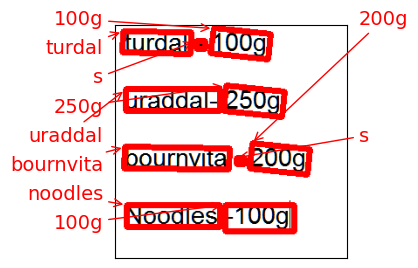

{'Tur Dal': '100g', 'Urad Dal': '250g', 'Bournvita': '200g', 'Noodles': '100g'}
                                    Name              Brand Price Quantity
0                          Tur Dal Latur                NaN    78   500 gm
1                        Udid (Urad) Dal                NaN    88   500 gm
2  Cadbury Bournvita Health Drink Refill  Cadbury Bournvita   320   750 gm
3   Sunfeast Yippee Noodles Magic Masala           Sunfeast   105   520 gm


In [16]:

image=["image3.png"]
def main(image):
    predictions=process_image(image)
    predictions=get_distance(predictions)
    predictions = list(distinguish_rows(predictions))
    predictions = list(filter(lambda x:x!=[], predictions))# Remove all empty rows

    ordered_preds = []
    order='yes'
    ylst = ['yes', 'y']
    for pr in predictions:
        if order in ylst: 
            row = sorted(pr, key=lambda x:x['distance_from_origin'])
            for each in row: 
                ordered_preds.append(each['text'])
    
    order = check_items(ordered_preds)
    print(order)
    df=fetch_data(order)
    print(df)
main(image)
    